In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.util as model_util
import model.mechint_net as mechint_net
import feature.experimental_dataset as experimental_dataset
import feature.util as feature_util
import train.train_model as train_model
import train.performance as performance
import plot.plot_motifs as plot_motifs
import analysis.motif_util as motif_util
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
import logomaker

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
# model_path = os.path.join(base_path, "models/trained_models/experimental/chipseq_rest_hepg2/mechint_net/filterlen_15/2/last_ckpt.pth")
# peak_bed_path = os.path.join(base_path, "data/encode/chipseq/ENCSR000BOT_REST_HepG2/ENCFF271FEM_idrpeaks.bed.gz")
# pairs_of_interest = [
#     (5, 3),
#     (6, 2)
# ]

In [6]:
# model_path = os.path.join(base_path, "models/trained_models/experimental/chipseq_rest_hepg2/mechint_net/frozen_filters/3/last_ckpt.pth")
# peak_bed_path = os.path.join(base_path, "data/encode/chipseq/ENCSR000BOT_REST_HepG2/ENCFF271FEM_idrpeaks.bed.gz")
# pairs_of_interest = [
#     (0, 2),
#     (3, 1)
# ]

In [7]:
model_path = os.path.join(base_path, "models/trained_models/experimental/chipseq_rest_k562/mechint_net/frozen_filters/3/last_ckpt.pth")
peak_bed_path = os.path.join(base_path, "data/encode/chipseq/ENCSR054JMQ_REST_K562/ENCFF118ECK_idrpeaks.bed.gz")
pairs_of_interest = [
    (0, 2),
    (3, 1)
]

In [8]:
# model_path = os.path.join(base_path, "models/trained_models/experimental/dnase_hepg2/mechint_net/3/last_ckpt.pth")
# peak_bed_path = os.path.join(base_path, "data/encode/dnase/ENCSR149XIL_HepG2/ENCFF897NME_peaks.bed.gz")
# pairs_of_interest = [
#     (13, 2),
#     (2, 13)
# ]

In [9]:
figures_out_path = "/home/tsenga5/mechint_regnet/figures/binding_syntax"
os.makedirs(figures_out_path, exist_ok=True)

### Import models and create data loader

In [10]:
model = model_util.load_model(
    mechint_net.MechIntRegNet, model_path
).to(DEVICE)

In [11]:
data_loader = experimental_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "peaks_bed_path": peak_bed_path,
        "batch_size": 128,
        "chrom_set": (["chr" + str(i) for i in range(1, 24)] + ["chrX"]),  # Entire dataset
        "negative_ratio": 0  # No negatives
    }
).result

WARNING - root - Added new config entry: "chrom_set"
WARNING - root - Added new config entry: "peaks_bed_path"
WARNING - exp_dataset - No observers have been added to this run
INFO - exp_dataset - Running command 'create_data_loader'
INFO - exp_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - exp_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x148abacf7440>
INFO - exp_dataset - Completed after 0:00:00


### Run predictions

In [12]:
_, _, model_outputs, _, model_outputs_other, input_data = \
    train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)

	Loss: 1.0444: 100%|█████████████████████████████████████| 163/163 [00:04<00:00, 35.00it/s]


In [13]:
true_labels = np.squeeze(input_data[1], axis=1)

In [14]:
conv_acts = model_outputs_other["conv_acts"]
att_vals = model_outputs_other["att_vals"]

### Extract motifs

In [15]:
def model_to_pfms(model, data_loader, max_thresh_frac=0.5):
    """
    Given a model and a data loader, runs through the input sequences
    in the data loader and collects convolutional activations from the
    entire epoch.
    Returns a F x W x 4 array of PFMs for the filters. If a filter is
    never activated, its PFM will be all 0.
    """
    _, _, _, _, model_outputs_other, input_data = \
        train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)
    conv_acts = model_outputs_other["conv_acts"]  # Shape: N x L' x F
    input_seqs = input_data[0]  # Shape: N x L x 4
    num_filters = conv_acts.shape[2]
    filter_width = input_seqs.shape[1] - conv_acts.shape[1] + 1

    # Compute minimum activations needed
    act_threshes = np.max(conv_acts, axis=(0, 1)) * max_thresh_frac

    # Construct PFMs
    pfms = np.zeros((num_filters, filter_width, 4))
    for i in range(num_filters):
        if act_threshes[i] == 0:
            continue
        ex_inds, start_inds = np.where(conv_acts[:, :, i] > act_threshes[i])
        if not ex_inds.size:
            # Nothing passed the threshold
            continue
        # Trick to get all matching subsequences, where we flatten the set of all
        # indices we want and then reshape
        seqs = input_seqs[
            np.repeat(ex_inds, filter_width),
            (np.arange(filter_width)[None] + start_inds[:, None]).reshape(-1)
        ].reshape(len(ex_inds), filter_width, -1)
        pfms[i] = np.mean(seqs, axis=0)

    return pfms

In [16]:
pfms = model_to_pfms(model, data_loader)

	Loss: 0.8468: 100%|█████████████████████████████████████| 163/163 [00:02<00:00, 58.50it/s]


/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


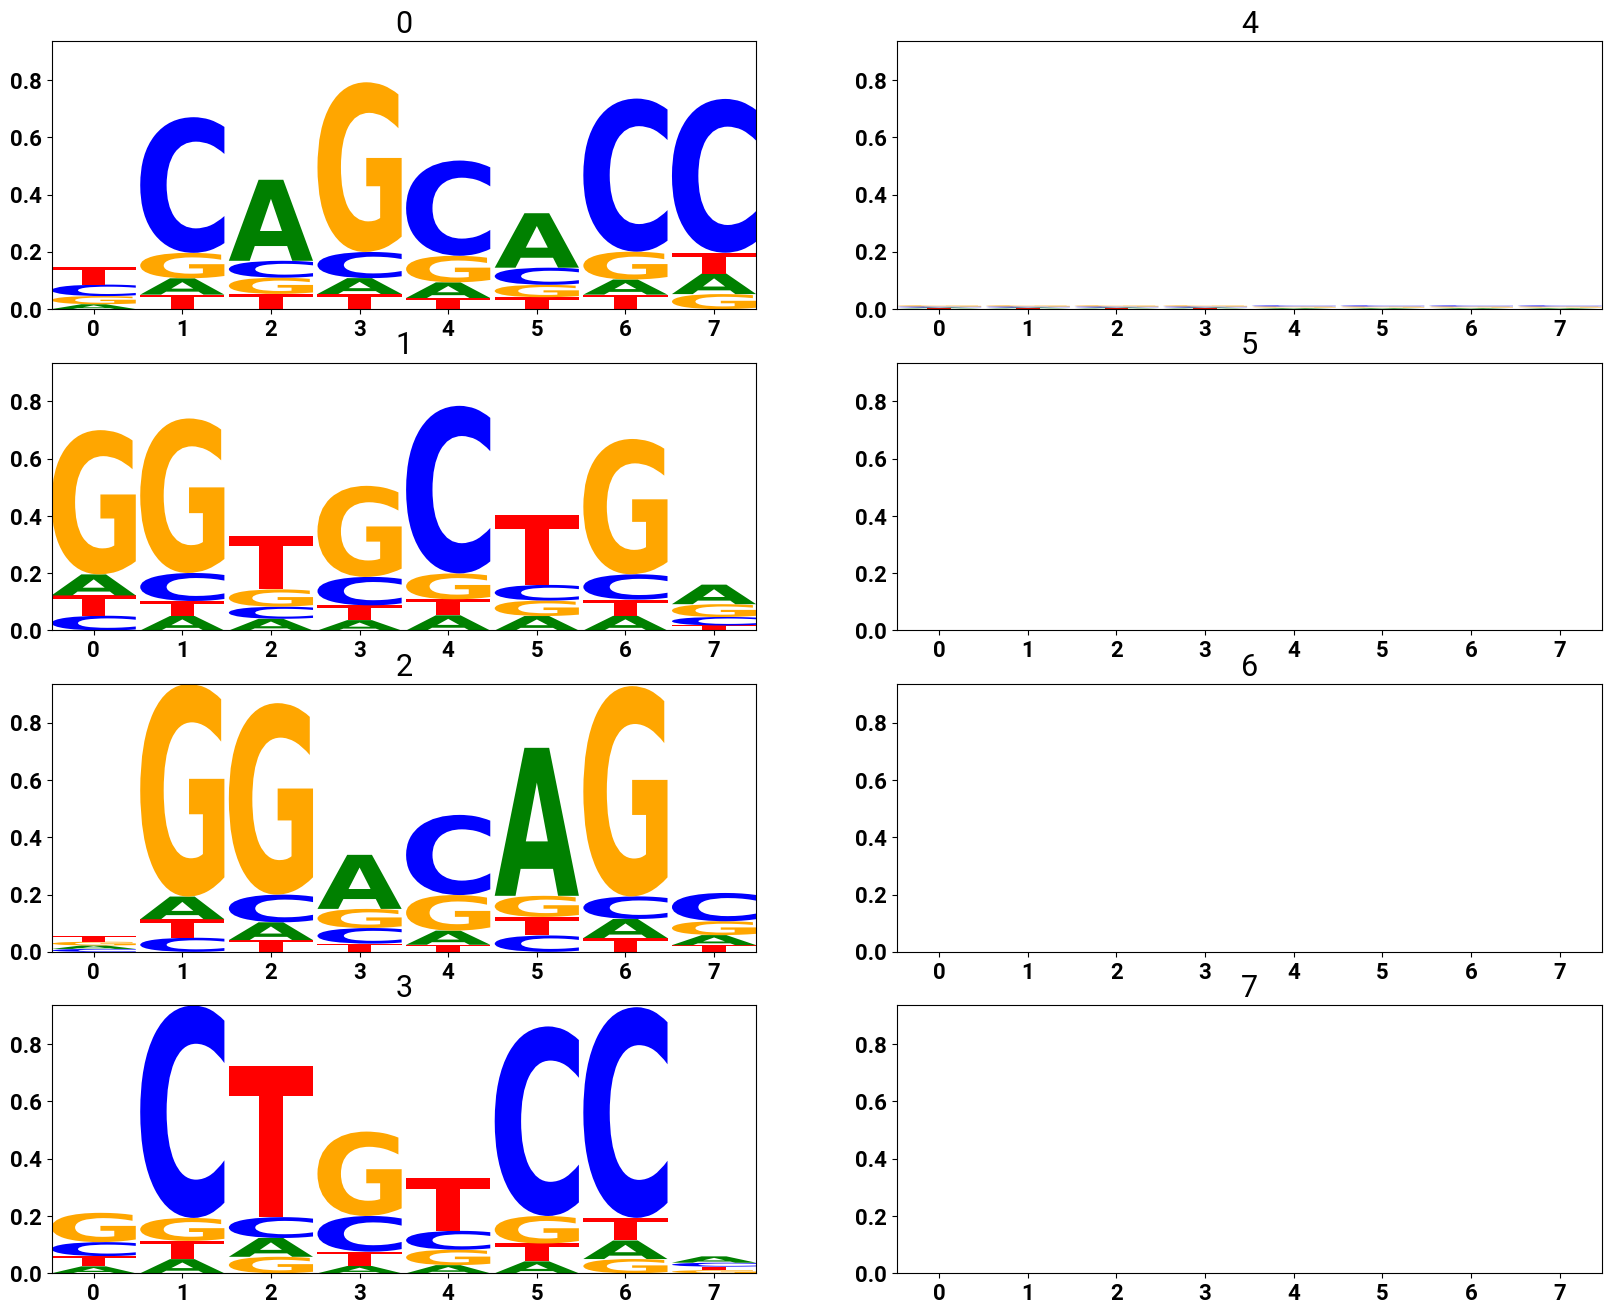

In [17]:
fig = plot_motifs.plot_motif_grid([pfm * motif_util.pfm_info_content(pfm)[:, None] for pfm in pfms], titles=[str(i) for i in range(len(pfms))])
fig.savefig(os.path.join(figures_out_path, "motifs.svg"), format="svg")
plt.show()

### Extract motif instances and global rules

In [18]:
# For each positive example, find the maximum attention values and map them to motifs (and their positions)
pos_att_vals = att_vals[true_labels == 1]
pos_conv_acts = conv_acts[true_labels == 1]

motif_hits = []

# For each filter, get a distribution activations
filter_mean_acts = np.empty(pos_conv_acts.shape[2])
for filter_i in range(pos_conv_acts.shape[2]):
    acts = pos_conv_acts[:, :, filter_i]
    acts = acts[acts > 0]  # Only positive activations
    filter_mean_acts[filter_i] = np.mean(acts)

# For each example, get the positions which had a high attention score
for ex_i in range(len(pos_att_vals)):
    att_scores = pos_att_vals[ex_i]  # Shape: AL x AH x L'

    # Get positions with high attention score
    mask = np.any(att_scores > 0.5, axis=(0, 1))  # Collapse over attention layers and heads
    inds = np.where(mask)[0]

    ex_motif_hits = []

    # For each position, figure out which motif is firing
    for hit_pos in inds:
        acts = pos_conv_acts[ex_i, hit_pos]
        filter_hits = acts > filter_mean_acts
        if not np.any(filter_hits):
            # Got a high attention score, but no motif hit here
            continue
        ex_motif_hits.append((hit_pos, tuple(np.where(filter_hits)[0])))
    motif_hits.append(sorted(ex_motif_hits, key=(lambda h: h[0])))  # Sort by position        

/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [19]:
def match_keys_to_sequence(keys, sequence, start_index=0):
    """
    Given a list of keys (e.g. [0, 1, 2]) and a longer sequence of similar
    keys as tuples (e.g. [(0, 1), (3,), (1, 2), (2, 4), (5,)]), matches the
    keys to the sequence and identifies the indices for which the keys are
    a subsequence of `sequence`, where each key just needs to be in the tuple
    at that position (e.g. [0, 2, 3] in the example above). Returns None if
    no matching is found.
    In the case that multiple matchings is possible, always returns the matching
    with the lowest-possible indices.
    """
    if not keys:
        return []
    if not sequence:
        return None
    if keys[0] in sequence[0]:
        rest = match_keys_to_sequence(keys[1:], sequence[1:], start_index + 1)
        if rest is None:
            return None
        return [start_index] + rest
    else:
        return match_keys_to_sequence(keys, sequence[1:], start_index + 1)

In [20]:
# Compute spacings from pairs of interest
spacings = {}
for pair in pairs_of_interest:
    spacings[pair] = []
    for hit_set in motif_hits:
        match_inds = match_keys_to_sequence(
            pair,
            [hit[1] for hit in hit_set]
        )
        if match_inds is None:
            continue

        spaces = np.diff([hit_set[i][0] for i in match_inds])
        spaces = spaces - pfms.shape[2]  # Subtract length of motifs
        spacings[pair].append(spaces[0])  # With pairs, we only have one space

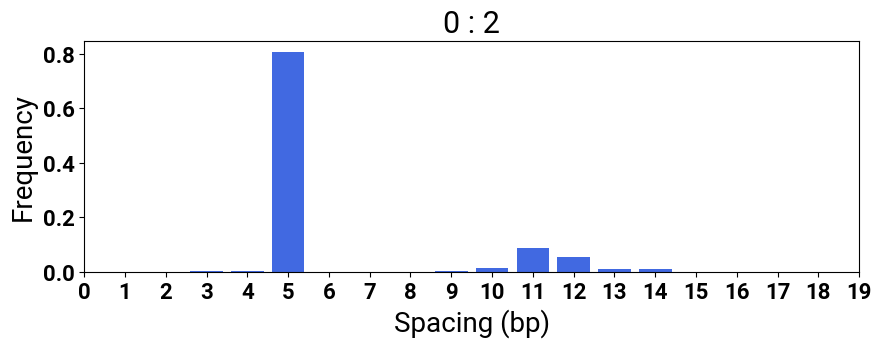

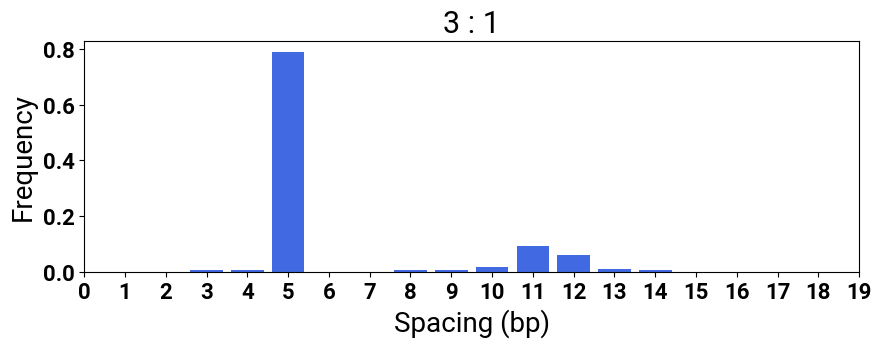

In [21]:
# Draw histograms of distances between pairs of motif instances
for pair in pairs_of_interest:
    fig, ax = plt.subplots(figsize=(10, 3))
    spaces = np.array(spacings[pair])
    spaces = spaces[spaces < 20]

    # Plot as bar plot, since we only have a few bins
    bins, counts = np.unique(spaces, return_counts=True)
    ax.bar(bins, counts / np.sum(counts), color="royalblue")
    ax.set_title(" : ".join([str(x) for x in pair]))
    ax.set_xticks(np.arange(20))
    ax.set_xlabel("Spacing (bp)")
    ax.set_ylabel("Frequency")
    
    fig.savefig(os.path.join(figures_out_path, "%d-%d_spacing.svg" % pair), format="svg")
    plt.show()

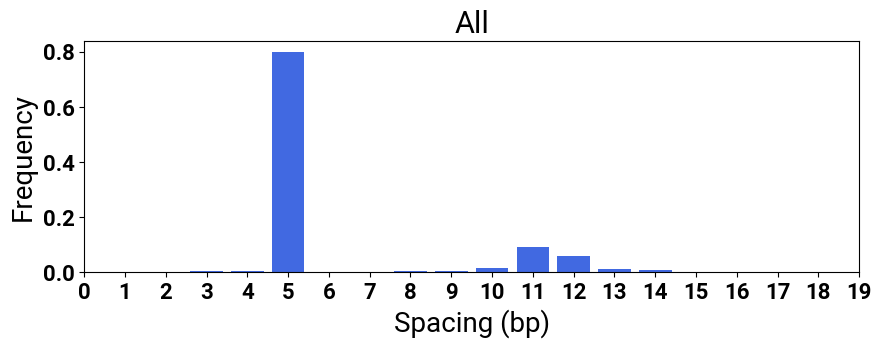

In [22]:
# Draw histogram for union of spacings
all_spaces = []
for pair in pairs_of_interest:
    spaces = np.array(spacings[pair])
    spaces = spaces[spaces < 20]
    all_spaces.append(spaces)
all_spaces = np.concatenate(all_spaces)

fig, ax = plt.subplots(figsize=(10, 3))
# Plot as bar plot, since we only have a few bins
bins, counts = np.unique(all_spaces, return_counts=True)
ax.bar(bins, counts / np.sum(counts), color="royalblue")
ax.set_title("All")
ax.set_xticks(np.arange(20))
ax.set_xlabel("Spacing (bp)")
ax.set_ylabel("Frequency")

fig.savefig(os.path.join(figures_out_path, "all_spacing.svg"), format="svg")
plt.show()